In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# increase matplotlib resolution
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

# where to save plots
overwrite = True
save_path = "/home/luke/Documents/thesis_plots/"

In [2]:
use_devel = True

# insert the mymujoco path for TrainDQN.py file
if use_devel:
  sys.path.insert(0, "/home/luke/mujoco-devel/rl")
else:
  sys.path.insert(0, "/home/luke/mymujoco/rl")

sys.path.insert(0, "/home/luke/gripper-ros/src/rl/gripper_dqn/scripts/")

# create modelsaver instance
from ModelSaver import ModelSaver
directory = ""#"pb4_tests_apr23" # ""
saver = ModelSaver(f"test_data/{directory}", root="/home/luke/gripper-ros/")

from grasp_test_data import GraspTestData, set_palm_frc_threshold, set_X_frc_threshold, set_Y_frc_threshold
data_explorer = GraspTestData()

# # enter folder and load test data
# test_name = "pb1_E2_S3_YCB_disturb"
# # test_name = "YCB_heuristic"
# saver.enter_folder(test_name)
# try:
#   testdata = saver.load(id=None, filenamestarts="test_data", suffix_numbering=True)
#   set_palm_frc_threshold(5.0)
#   set_X_frc_threshold(10.0)
#   set_Y_frc_threshold(10.0)
#   data_explorer.add_palm_start_force = False
#   print(data_explorer.get_test_string(data=testdata, detailed=2))

#   # set_palm_frc_threshold(3.0)
#   # print(data_explorer.get_test_string(data=testdata, detailed=True))
# except TypeError as e:
#   print("Loading test data failed, check that the test has actually saved some data")
#   print("Error was:", e)

In [3]:
def get_test_data(tests, Xt=10.0, Yt=10.0, Zt=10.0, add_palm_frc=False, printout=False):

  saver.log_level = 0

  combined_trials = []
  if not isinstance(tests, list):
    tests = [tests]
  for name in tests:
    saver.enter_folder(name)
    testdata = saver.load(id=None, filenamestarts="test_data", suffix_numbering=True)
    for t in testdata.trials:
      combined_trials.append(t)

  testdata.trials = combined_trials
  set_palm_frc_threshold(Zt)
  set_X_frc_threshold(Xt)
  set_Y_frc_threshold(Yt)
  data_explorer.add_palm_start_force = add_palm_frc

  if printout:
    print(data_explorer.get_test_string(data=testdata, detailed=True))

  return data_explorer.get_test_results(data=testdata)

# enter folder and load test data
test_names = ["pb1_E2_S3_real", "pb1_E2_S3_real_disturb"]
test_names = ["pb1_E2_S3_YCB", "palm_E2_75_YCB_e2"]
test_names = ["real_heuristic", "real_heuristic_disturb"]

In [4]:
def combine(item1, item2):
  out = []
  if isinstance(item1, list):
    out = item1
  else: out.append(item1)
  if isinstance(item2, list):
    out += item2
  else: out.append(item2)
  return out

real_tests = [
  ["pb1_E2_S3_real", "pb1_E2_S3_real_disturb_extended"],
  ["real_heuristic", "real_heuristic_disturb_extended"],
  ["shaped_MAT_real", "shaped_MAT_real_disturb"], 
  ["MAT_liftonly_real", "MAT_liftonly_real_disturb"],
]
real_disturb_tests = [
  "pb1_E2_S3_real_disturb_extended",
  "real_heuristic_disturb",
  ["shaped_MAT_real_disturb", "shaped_MAT_real"],
  ["MAT_liftonly_real_disturb", "MAT_liftonly_real"],
]
ycb_tests = [
  ["pb1_E2_S3_YCB", "pb1_E2_S3_YCB_disturb"],
  ["YCB_heuristic", "YCB_heuristic_disturb"],
  ["shaped_MAT_ycb", "shaped_MAT_ycb_disturb"],
  ["MAT_liftonly_ycb", "MAT_liftonly_ycb_disturb"],
]
ycb_disturb_tests = [
  "pb1_E2_S3_YCB_disturb", # palm_E2_75_YCB_e2, this test should be repeated, data is incomplete
  "YCB_heuristic_disturb",
  ["shaped_MAT_ycb_disturb", "shaped_MAT_ycb"],
  ["MAT_liftonly_ycb_disturb", "MAT_liftonly_ycb"],
]
controllers = ["PPO (ours)", "Heuristic", "MAT + ours", "MAT"]

headers = f"{'Controller':<12} | {'Objects':<8} | {'Finger / N':<12} | {'Palm / N':<12} | {'Steps':<8} | {'X tol / N':<9} | {'Y tol / N':<9} | {'Z tol / N':<9} | {'SR %':<8} | {'Stable 5N %':<12} | {'Trials':<6}"
rows = "{:<12} | {:<8} | {:<12.3f} | {:<12.3f} | {:<8.2f} | {:<9.3f} | {:<9.3f} | {:<9.3f} | {:<8.2f} | {:<12.2f} | {:<6}"

# add in 95 confidence interval to success rate and stable 5N rate
add_stat_sig = True
if add_stat_sig:
  headers += f" | {'SR 95CI%':<8} | {'+':<5} | {'-':<5} | {'S5N 95CI%':<9} | {'+':<5} | {'-':<5}"
  rows += " | {:<8.2f} | {:<5.2f} | {:<5.2f} | {:<9.2f} | {:<5.2f} | {:<5.2f}"

print(headers)

real_objects = []
ycb_objects = []

print_alternating = False
print_singles = True
print_both = False

if print_singles:
  for i in range(4 * (1 + (not print_alternating))):
    ind = i
    if print_alternating or i >= 4:
      if not print_alternating: ind -= 4
      ycb_disturb = get_test_data(ycb_disturb_tests[ind], Zt=10.0)
      ycb_main = get_test_data(ycb_tests[ind], Zt=10.0)
      ycb_5N = get_test_data(ycb_tests[ind], Zt=5.0)
      ycb_format = [controllers[ind], "YCB", ycb_main.avg_f_frc, ycb_main.avg_p_frc, ycb_main.avg_steps,
                    ycb_disturb.avg_X_frc_saturated, ycb_disturb.avg_Y_frc_saturated, 
                    ycb_disturb.avg_palm_frc_saturated,
                    ycb_main.avg_SR_per_obj * 100, ycb_5N.rate_palm_frc_tol * 100,
                    ycb_main.num_trials]
      if add_stat_sig:
        ycb_format += [ycb_main.CI_95 * 100, ycb_main.CI_95_max * 100, ycb_main.CI_95_min * 100, 
                      ycb_5N.CI_95_s5N * 100, ycb_5N.CI_95_s5N_max * 100, ycb_5N.CI_95_s5N_min * 100]
      print(rows.format(*ycb_format))
      ycb_objects.append(list(ycb_main.object_sr)[:18])
    if print_alternating or i < 4:
      real_disturb = get_test_data(real_disturb_tests[ind], Zt=10.0)
      real_main = get_test_data(real_tests[ind], Zt=10.0)
      real_5N = get_test_data(real_tests[ind], Zt=5.0)
      real_format = [controllers[ind], "Real", real_main.avg_f_frc, real_main.avg_p_frc, real_main.avg_steps,
                    real_disturb.avg_X_frc_saturated, real_disturb.avg_Y_frc_saturated, 
                    real_disturb.avg_palm_frc_saturated,
                    real_main.avg_SR_per_obj * 100, real_5N.rate_palm_frc_tol * 100,
                    real_main.num_trials]
      if add_stat_sig:
        real_format += [real_main.CI_95 * 100, real_main.CI_95_max * 100, real_main.CI_95_min * 100, 
                        real_5N.CI_95_s5N * 100, real_5N.CI_95_s5N_max * 100, real_5N.CI_95_s5N_min * 100]
      print(rows.format(*real_format))
      real_objects.append(list(real_main.object_sr)[:24])
    
if print_both:
  for ind in range(4):
    both_disturb = get_test_data(combine(ycb_disturb_tests[ind], real_disturb_tests[ind]), Zt=10.0)
    both_main = get_test_data(combine(ycb_tests[ind], real_tests[ind]), Zt=10.0)
    both_5N = get_test_data(combine(ycb_tests[ind], real_tests[ind]), Zt=5.0)
    both_format = [controllers[ind], "YCB+real", both_main.avg_f_frc, both_main.avg_p_frc, both_main.avg_steps,
                   both_disturb.avg_X_frc_saturated, both_disturb.avg_Y_frc_saturated, 
                   both_disturb.avg_palm_frc_saturated,
                   both_main.avg_SR_per_obj * 100, both_5N.rate_palm_frc_tol * 100,
                   both_main.num_trials]
    if add_stat_sig:
      both_format += [both_main.CI_95 * 100, both_main.CI_95_max * 100, both_main.CI_95_min * 100, 
                      both_5N.CI_95_s5N * 100, both_5N.CI_95_s5N_max * 100, both_5N.CI_95_s5N_min * 100]
    print(rows.format(*both_format))

Controller   | Objects  | Finger / N   | Palm / N     | Steps    | X tol / N | Y tol / N | Z tol / N | SR %     | Stable 5N %  | Trials | SR 95CI% | +     | -     | S5N 95CI% | +     | -    
PPO (ours)   | Real     | 0.000        | 0.000        | 40.37    | 4.470     | 5.285     | 7.556     | 95.83    | 79.67        | 240    | 1.45     | 96.92 | 94.38 | 2.65      | 82.08 | 77.02
Heuristic    | Real     | 0.000        | 0.000        | 85.77    | 4.551     | 4.538     | 5.914     | 77.55    | 52.74        | 243    | 2.71     | 80.05 | 74.84 | 3.13      | 55.85 | 49.61
MAT + ours   | Real     | 1.586        | 1.825        | 40.36    | 3.910     | 4.628     | 5.877     | 78.20    | 62.24        | 177    | 3.17     | 81.08 | 75.03 | 3.61      | 65.72 | 58.64
MAT          | Real     | 1.536        | 0.035        | 16.66    | 3.141     | 2.592     | 5.573     | 73.17    | 53.33        | 159    | 3.56     | 76.46 | 69.62 | 3.87      | 57.16 | 49.47
PPO (ours)   | YCB      | 0.000        | 0.00

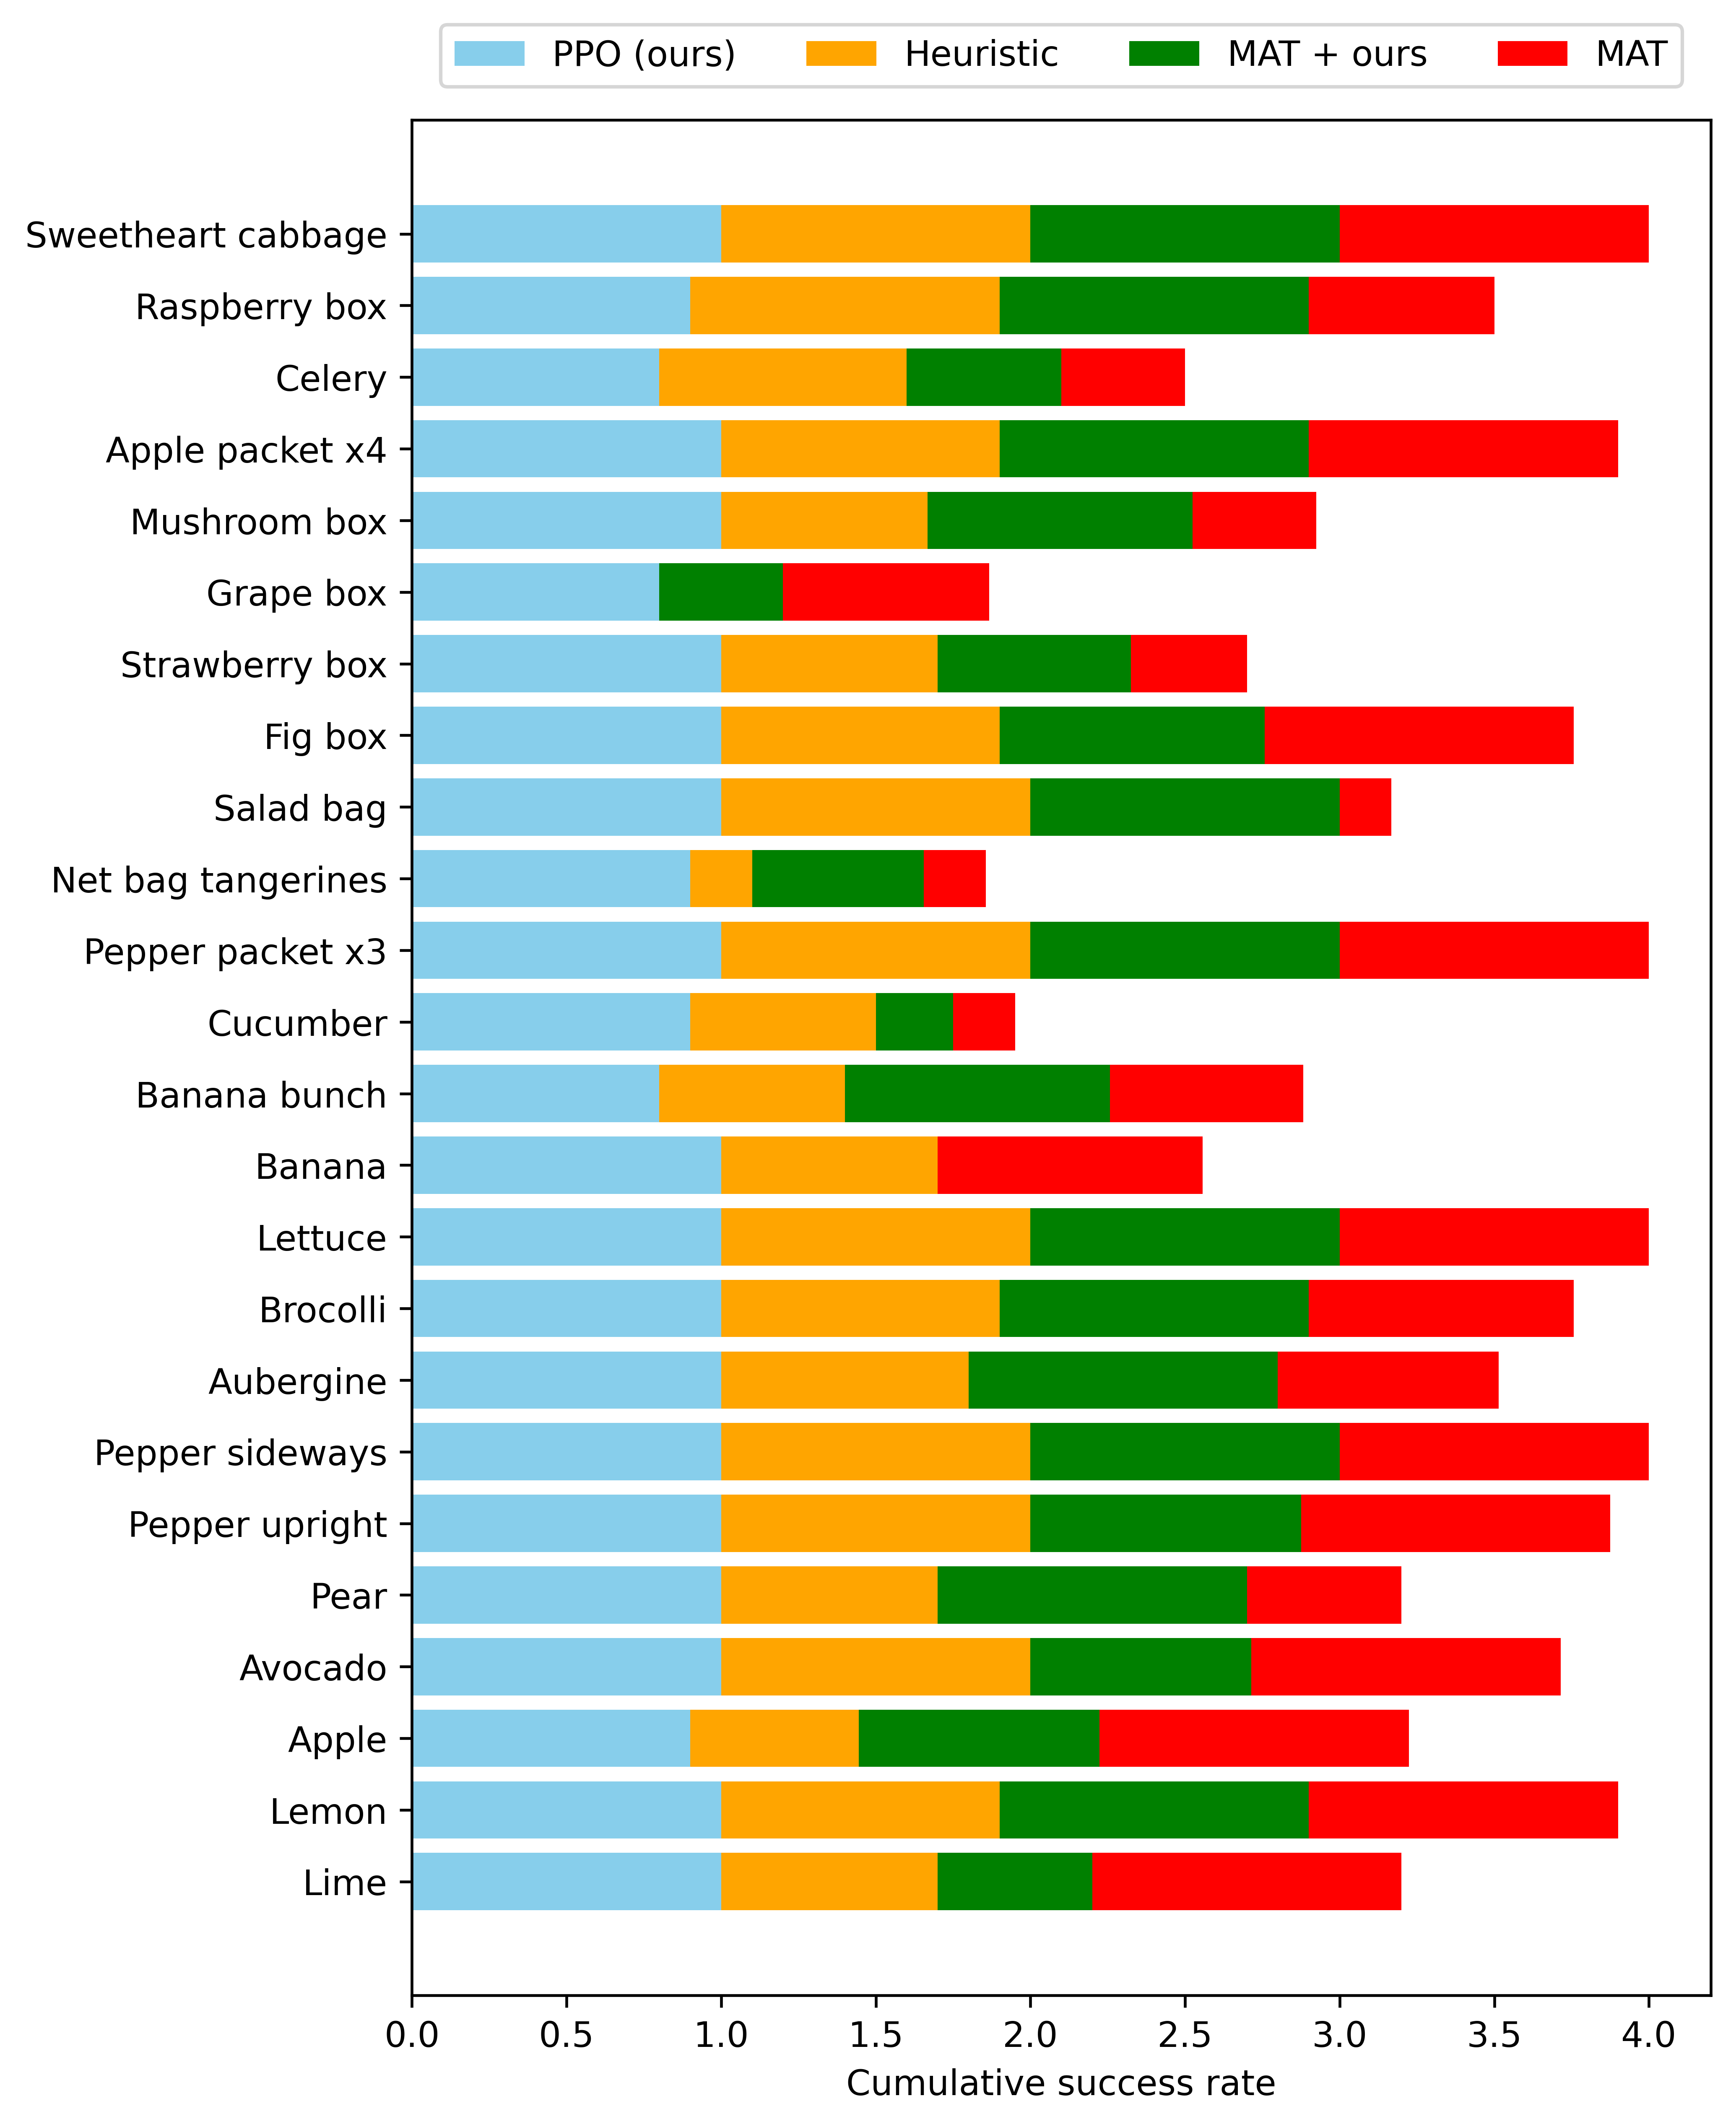

In [5]:
import matplotlib.pyplot as plt
import numpy as np

real_categories = ["Lime", "Lemon", "Apple", "Avocado", "Pear", "Pepper upright", "Pepper sideways", "Aubergine",
              "Brocolli", "Lettuce", "Banana", "Banana bunch", "Cucumber", "Pepper packet x3", "Net bag tangerines",
              "Salad bag", "Fig box", "Strawberry box", "Grape box", "Mushroom box", "Apple packet x4",
              "Celery", "Raspberry box", "Sweetheart cabbage"]

real_data = np.array(real_objects).transpose()

# Colors and labels for the 4 elements in each stack
colors = ['skyblue', 'orange', 'green', 'red']
labels = ['PPO (ours)', 'Heuristic', 'MAT + ours', 'MAT']

# Bar plot configuration
fig, ax = plt.subplots(figsize=(12, 10))

# Stacking the bars
bars = []
for i in range(real_data.shape[1]):
    bars.append(ax.barh(real_categories, real_data[:, i], color=colors[i], left=np.sum(real_data[:, :i], axis=1), label=labels[i]))

# Adding labels and title
ax.set_xlabel('Cumulative success rate')
# ax.set_title('Grasp success rate on real grocery items')
ax.legend(ncols=4, loc="upper center", bbox_to_anchor=(0.5, 1.06))

# Display the plot
fig.set_size_inches(7, 8.5)
fig.tight_layout()

if False and overwrite: fig.savefig(save_path + "real_object_success_rates.png")

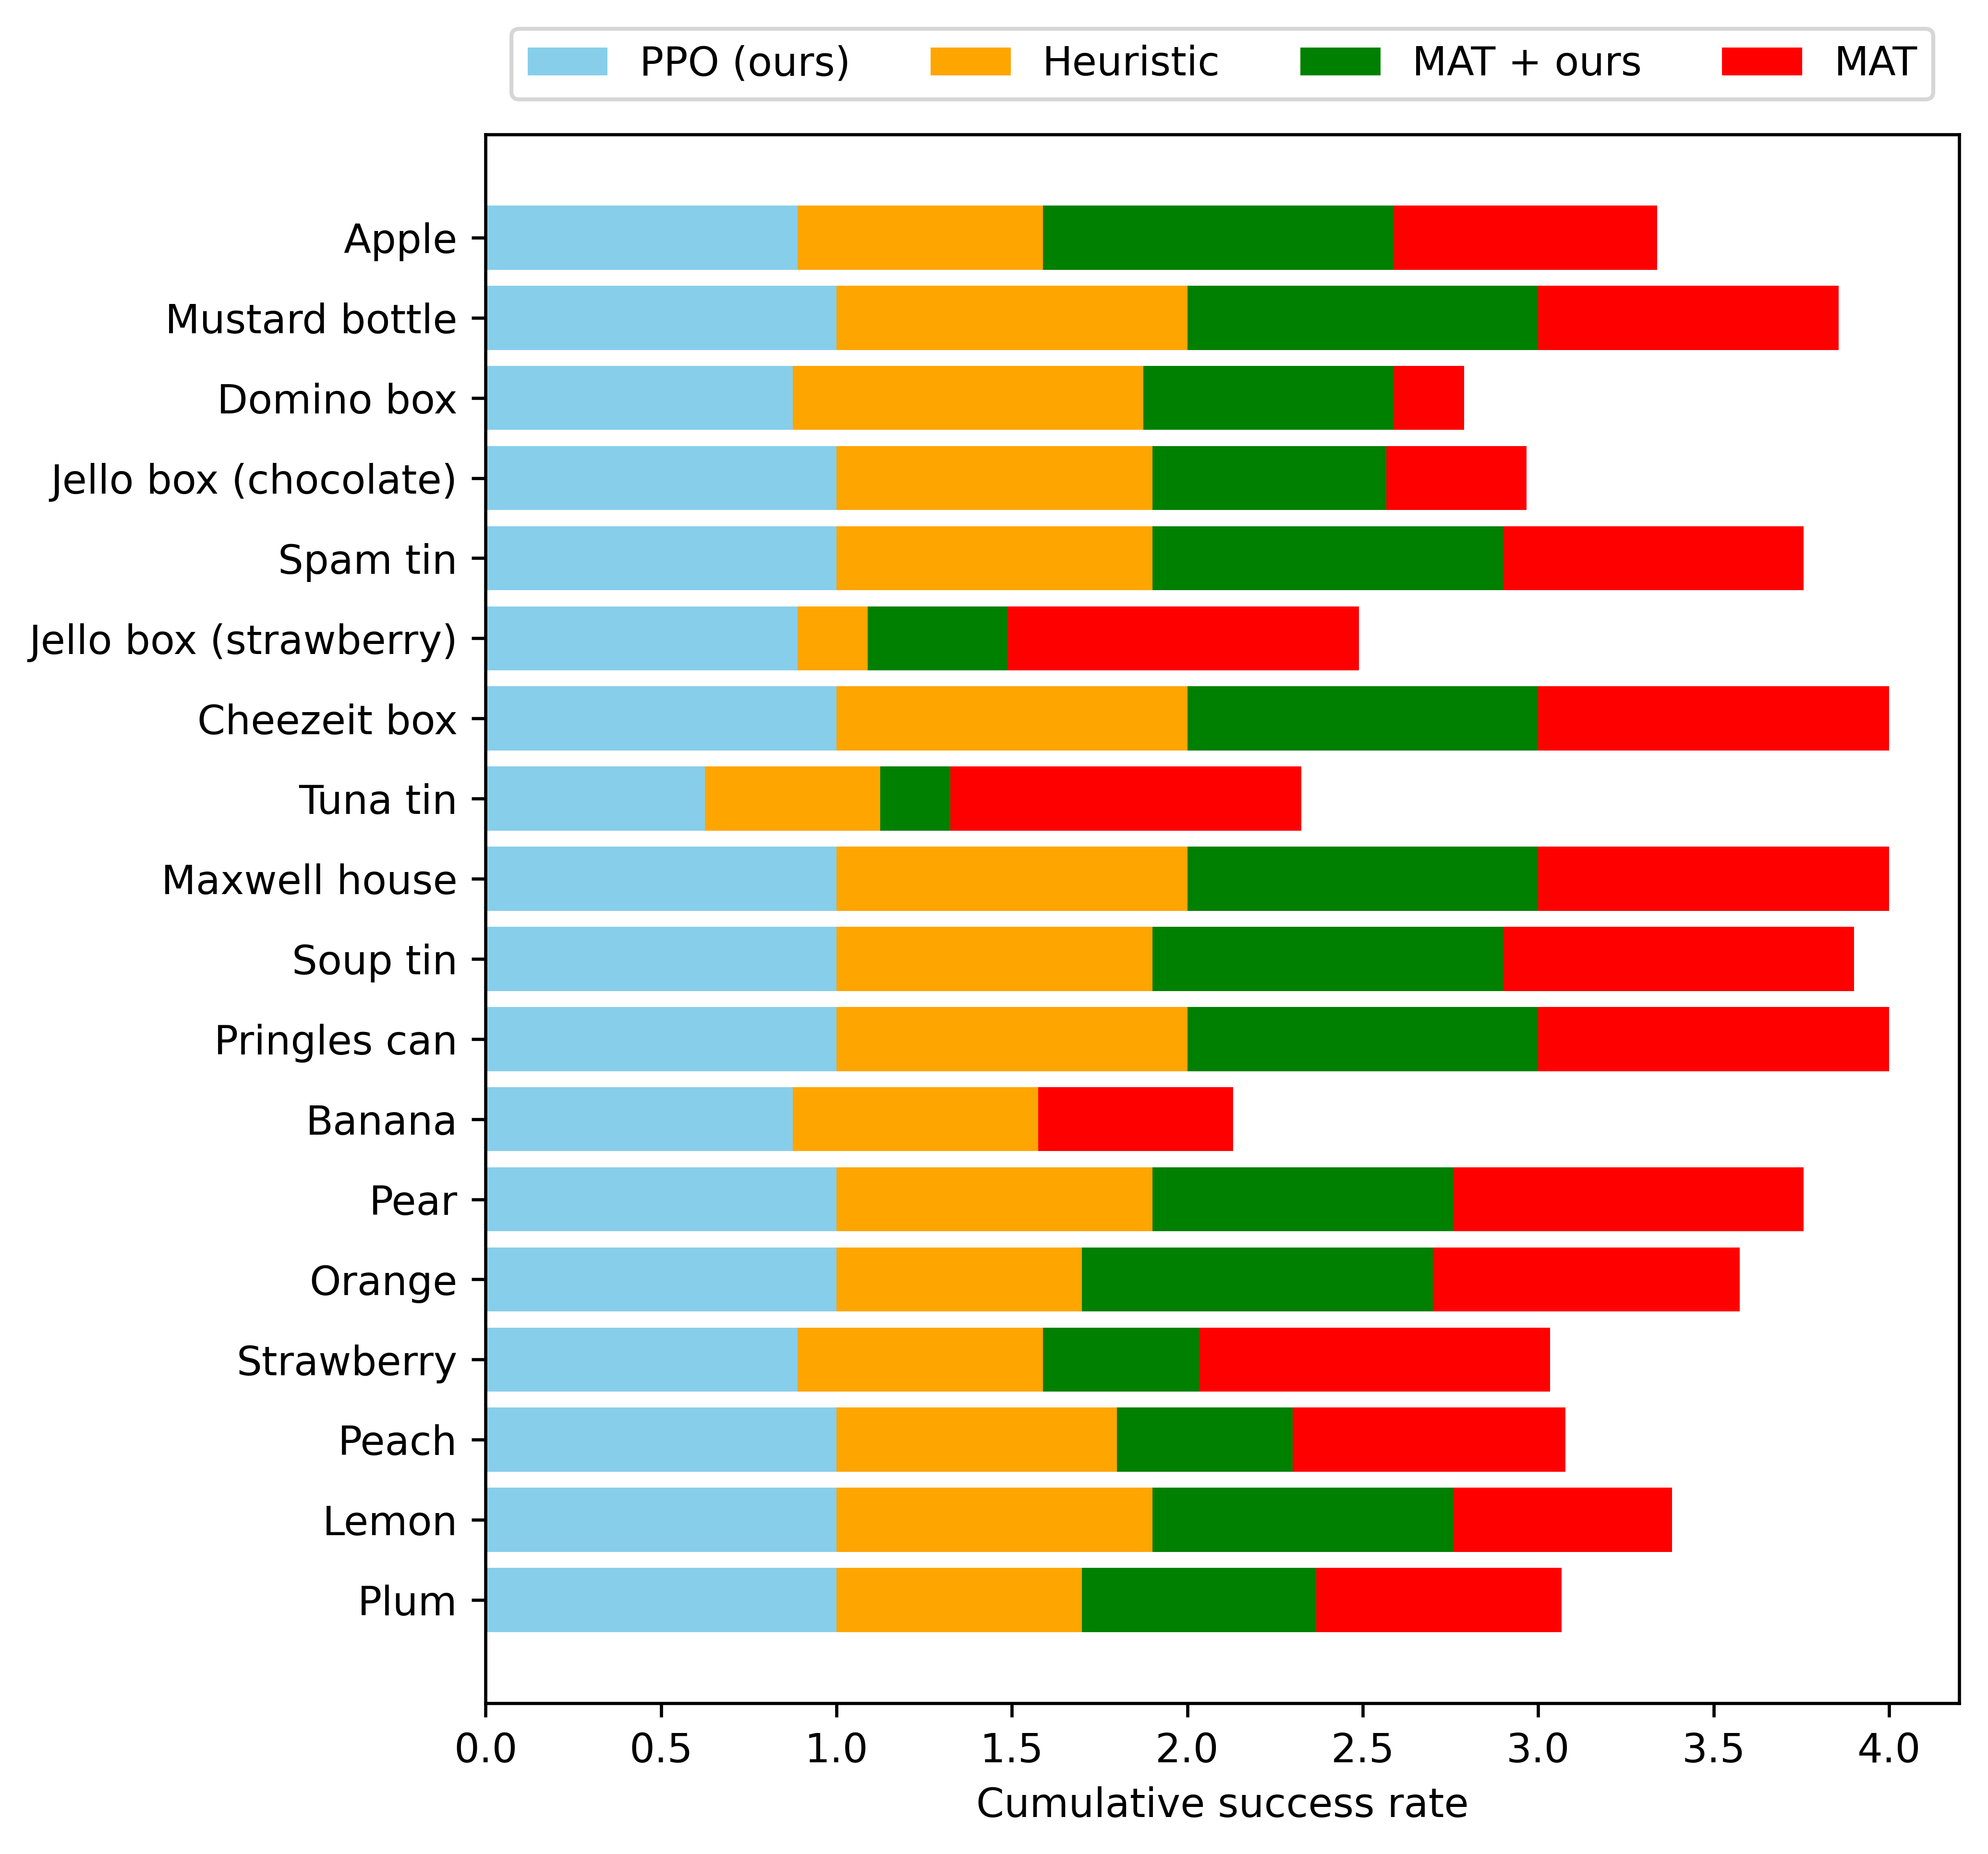

In [6]:
ycb_categories = ["Plum", "Lemon", "Peach", "Strawberry", "Orange", "Pear", "Banana", "Pringles can", "Soup tin",
                  "Maxwell house", "Tuna tin", "Cheezeit box", "Jello box (strawberry)", "Spam tin", "Jello box (chocolate)",
                  "Domino box", "Mustard bottle", "Apple"]

ycb_data = np.array(ycb_objects).transpose()

# Colors and labels for the 4 elements in each stack
colors = ['skyblue', 'orange', 'green', 'red']
labels = ['PPO (ours)', 'Heuristic', 'MAT + ours', 'MAT']

# Bar plot configuration
fig, ax = plt.subplots(figsize=(12, 10))

# Stacking the bars
bars = []
for i in range(ycb_data.shape[1]):
    bars.append(ax.barh(ycb_categories, ycb_data[:, i], color=colors[i], left=np.sum(ycb_data[:, :i], axis=1), label=labels[i]))

# Adding labels and title
ax.set_xlabel('Cumulative success rate')
# ax.set_title('Grasp success rate on YCB grocery items')
ax.legend(ncols=4, loc="upper center", bbox_to_anchor=(0.5, 1.08))

# Display the plot
fig.set_size_inches(7, 6.5)
fig.tight_layout()

if False and overwrite: fig.savefig(save_path + "ycb_object_success_rates.png")

In [7]:
header = f"{'Type':<8} | {'Name':<24} | {'PPO':<8} | {'Heur.':<8} | {'MAT+ours':<8} | {'MAT':<8} | {'All':<8}"
rows = "{:<8} | {:<24} | {:<8.2f} | {:<8.2f} | {:<8.2f} | {:<8.2f} | {:<8.2f}"

print(header)

for i in range(len(real_categories)):
  print(rows.format("Real", real_categories[i], real_data[i, 0], real_data[i, 1], real_data[i, 2], real_data[i, 3], np.average(real_data[i, :],)))

for i in range(len(ycb_categories)):
  print(rows.format("YCB", ycb_categories[i], ycb_data[i, 0], ycb_data[i, 1], ycb_data[i, 2], ycb_data[i, 3], np.average(ycb_data[i, :],)))

Type     | Name                     | PPO      | Heur.    | MAT+ours | MAT      | All     
Real     | Lime                     | 1.00     | 0.70     | 0.50     | 1.00     | 0.80    
Real     | Lemon                    | 1.00     | 0.90     | 1.00     | 1.00     | 0.97    
Real     | Apple                    | 0.90     | 0.55     | 0.78     | 1.00     | 0.81    
Real     | Avocado                  | 1.00     | 1.00     | 0.71     | 1.00     | 0.93    
Real     | Pear                     | 1.00     | 0.70     | 1.00     | 0.50     | 0.80    
Real     | Pepper upright           | 1.00     | 1.00     | 0.88     | 1.00     | 0.97    
Real     | Pepper sideways          | 1.00     | 1.00     | 1.00     | 1.00     | 1.00    
Real     | Aubergine                | 1.00     | 0.80     | 1.00     | 0.71     | 0.88    
Real     | Brocolli                 | 1.00     | 0.90     | 1.00     | 0.86     | 0.94    
Real     | Lettuce                  | 1.00     | 1.00     | 1.00     | 1.00     | 1.00    

In [8]:
filepath = "/home/luke/Documents/thesis_data/"
irregularity_data = pd.read_csv(filepath + "object_irregularity.csv")
position_data = pd.read_csv(filepath + "uncertainty_matrix.csv")
finger_scaling_data = pd.read_csv(filepath + "finger_scaling.csv")
palm_scaling_data = pd.read_csv(filepath + "palm_scaling.csv")

Circle threshold is 85.0%
Average success rate within 25.0mm circle is 86.67%
Average success rate within 35.0mm circle is 95.00%
Average success rate within 70mm circle (maximum size) is 94.67%
Average success rate within 43.0mm circle is 93.33%
Average success rate within 51.0mm circle is 86.67%
Average success rate within 43.0mm circle is 86.67%


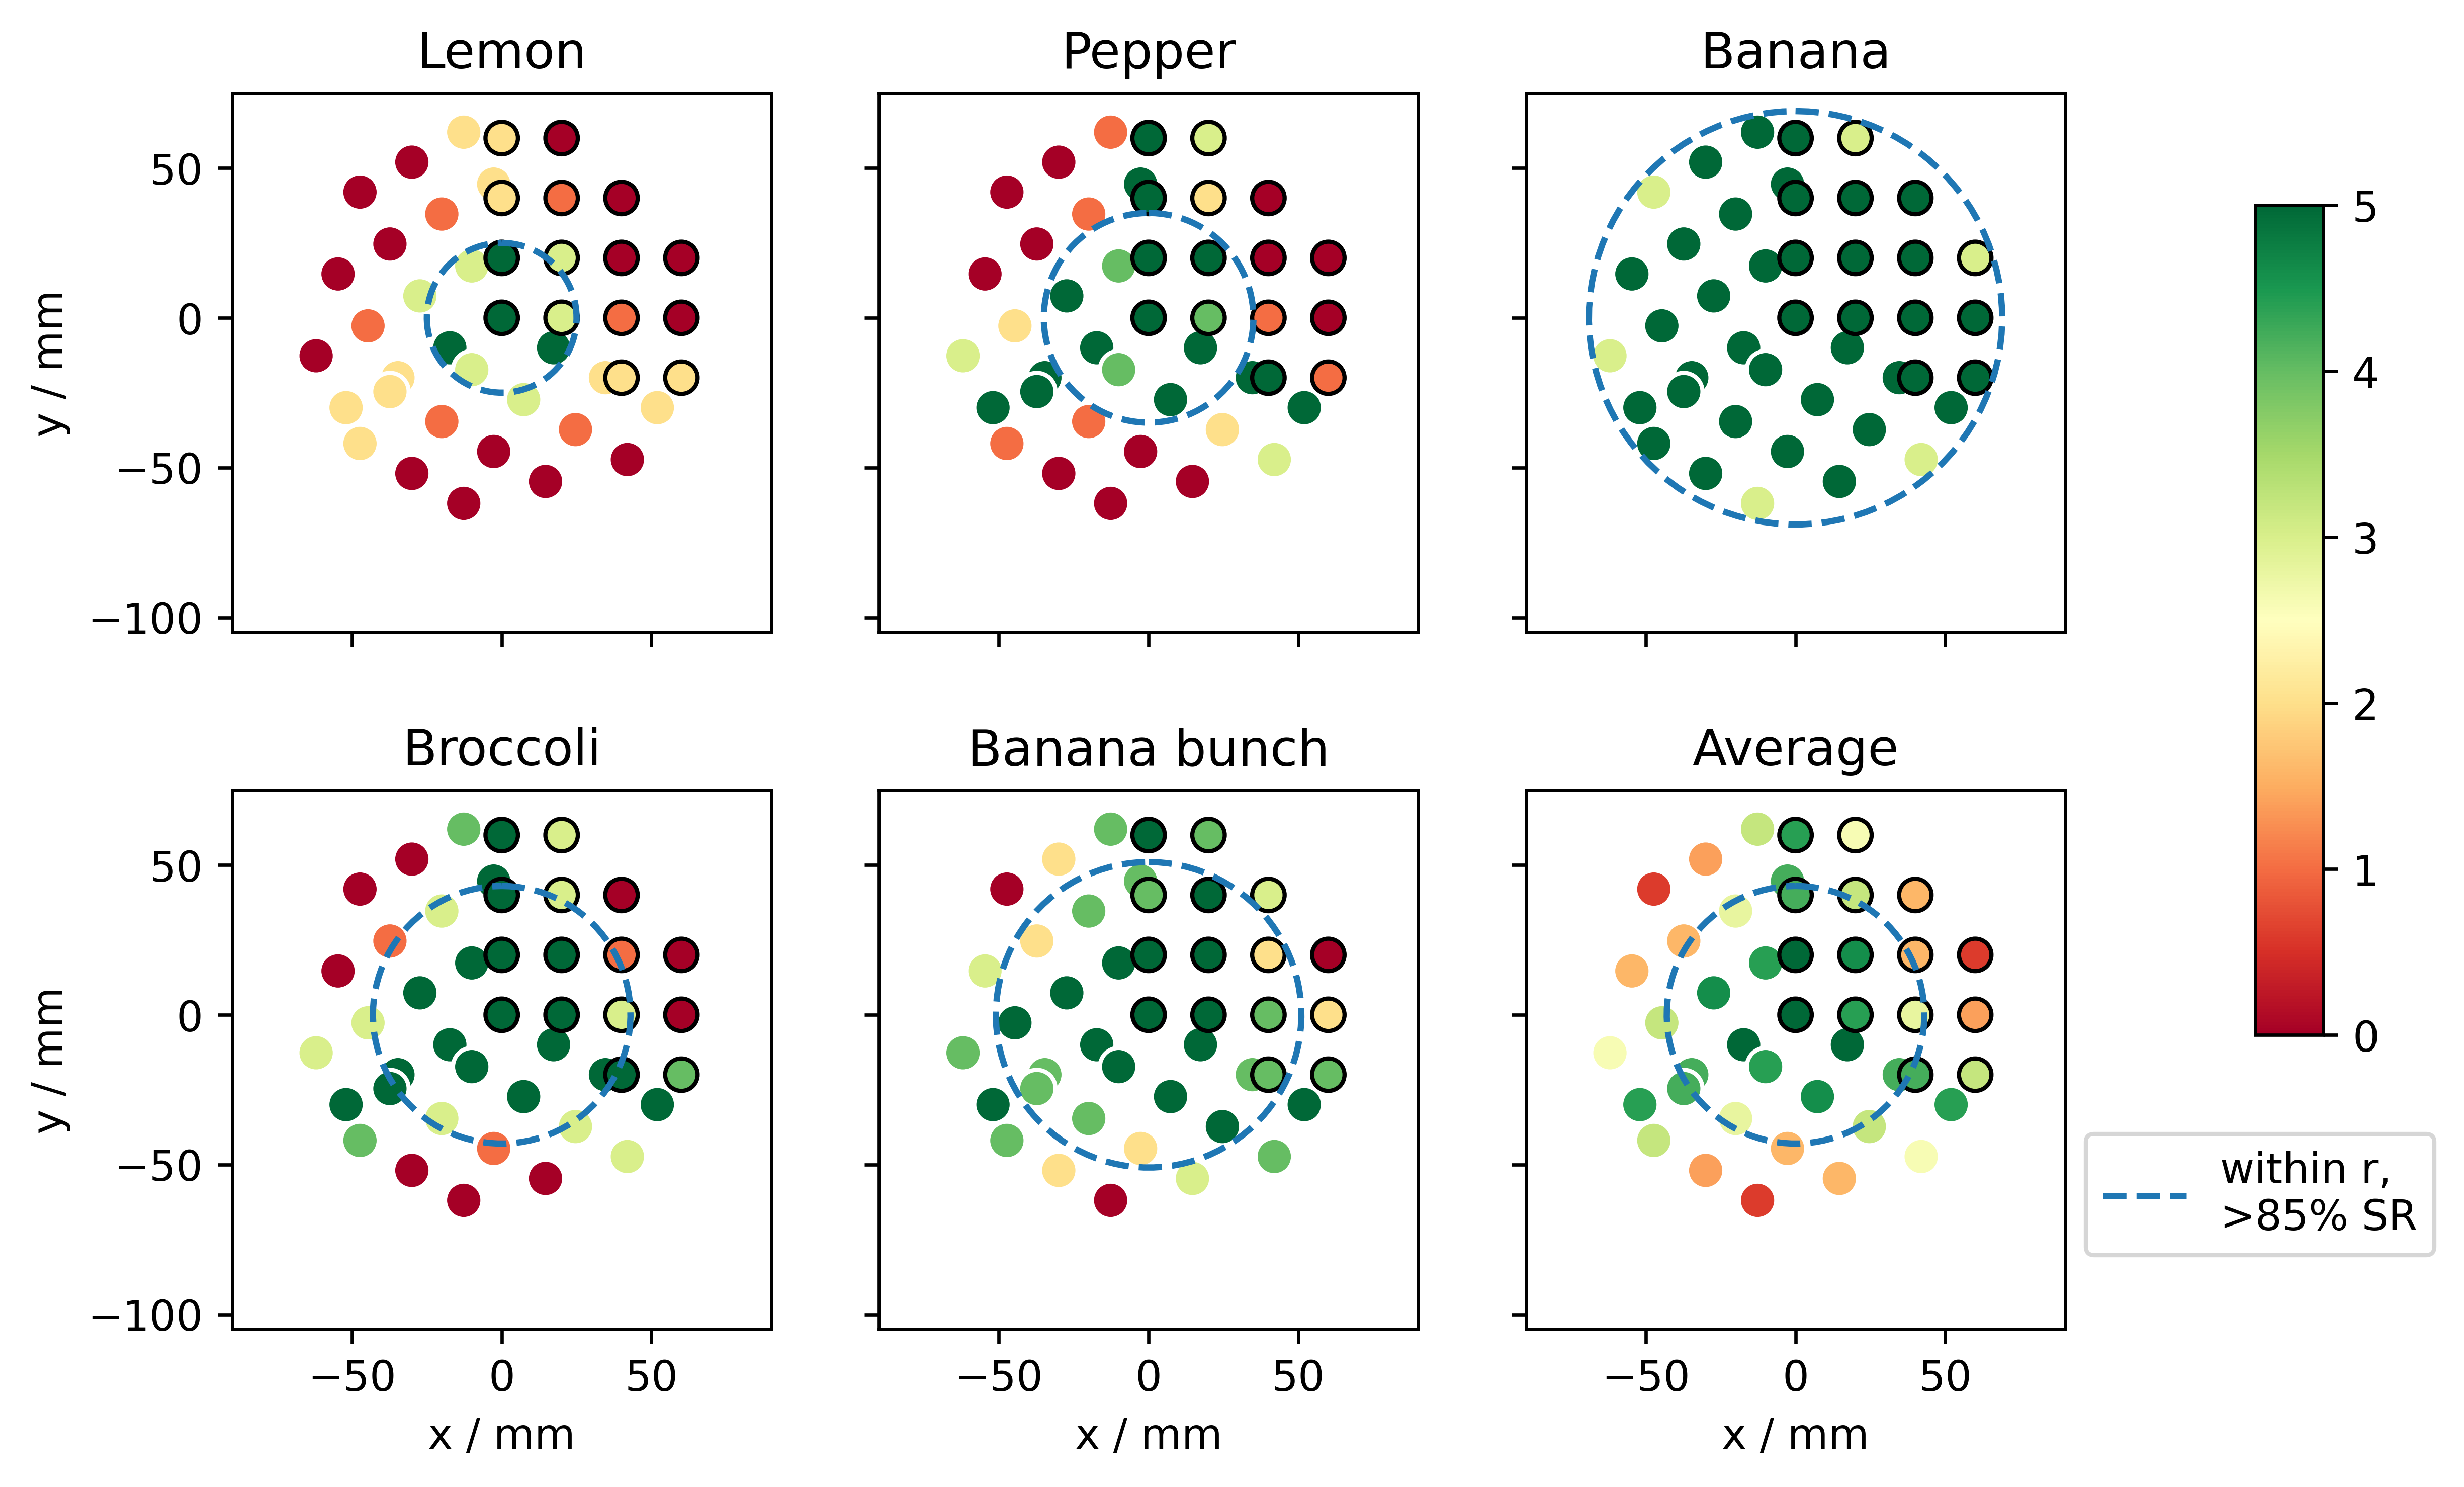

In [9]:
def get_circle(threshold):
  last_change_radius = 0
  last_sr = 1.1
  tol = 1e-5
  maxr = 70
  for radius in list(range(15, 70)):
    # radius = 70
    th = np.linspace(0, np.pi * 2, 100)
    circle = np.zeros((2, 100))
    circle[0, :] = radius * np.sin(th)
    circle[1, :] = radius * np.cos(th)
    sr_avg = 0
    count = 0
    for i, p in enumerate(points_basic):
      if np.sqrt(points_basic[i, 0]**2 + points_basic[i, 1]**2) < radius:
        sr_avg += xy_data[i]
        count += 1
    sr = (sr_avg / count) / 5
    if abs(sr - last_sr) > tol:
      if sr < threshold:
        final_radius = 0.5 * (radius + last_change_radius)
        th = np.linspace(0, np.pi * 2, 100)
        circle = np.zeros((2, 100))
        circle[0, :] = final_radius * np.sin(th)
        circle[1, :] = final_radius * np.cos(th)
        print(f"Average success rate within {final_radius}mm circle is {100 * last_sr:.2f}%")
        return circle, final_radius
      else:
        last_change_radius = radius
        last_sr = sr

  print(f"Average success rate within {maxr}mm circle (maximum size) is {100 * sr:.2f}%")
  return circle, maxr

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
axs = axs.flatten(order="C")
names = ["Lemon", "Pepper", "Banana", "Broccoli", "Banana bunch", "Average"]

points_basic = np.array([
  [0, 0], [0, 20], [0, 40], [0, 60],
  [20, 0], [20, 20], [20, 40], [20, 60],
  [40, -20], [40, 0], [40, 20], [40, 40],
  [60, -20], [60, 0], [60, 20]
], dtype=np.float32)

# remove point 8
remove_8 = False
if remove_8:
  points_basic = np.delete(points_basic, 8, axis=0)

# plot a circle to indicate points within exceed a threshold on average
plot_circle = True
circle_threshold = 0.85
if plot_circle: print(f"Circle threshold is {circle_threshold * 100:.1f}%")

points = np.copy(points_basic)

angles = [np.pi * (2/3), np.pi * (4/3)]

# add in two other symettric parts of the circle
num_points = len(points)
for theta in angles:
  rotation_matrix = np.array([
                      [np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]
                    ])
  for i in range(1, num_points):
    xy = np.vstack((points[i][0], points[i][1]))
    new_xy = np.transpose(np.dot(rotation_matrix, xy))
    # r = np.sqrt(points[i][0]*points[i][0] + points[i][1]+points[i][1])
    # new_x = points[i][0] * np.cos(th) + points[i][1] + np.sin(th)
    # new_y = points[i][0] * np.sin(th) - points[i][1] + np.cos(th)
    points = np.concatenate([points, new_xy], axis=0)


for i, name in enumerate(names):
  xy_data = position_data[name]
  if remove_8:
    xy_data = np.delete(xy_data, 8, axis=0)

  triple_data = np.concatenate([xy_data, xy_data[1:], xy_data[1:]], axis=0)

  # Create a colormap from red to green
  cmap = plt.get_cmap('RdYlGn')

  # # Plotting
  # fig, ax = plt.subplots()

  from matplotlib.colors import Normalize
  norm = Normalize(vmin=0, vmax=5)

  # Scatter plot with colored circles and black edge
  sc = axs[i].scatter(points[:,0], points[:,1], c=triple_data, norm=norm, cmap=cmap, edgecolors='white', s=80)
  sc = axs[i].scatter(points_basic[:,0], points_basic[:,1], c=xy_data, norm=norm, cmap=cmap, edgecolors='black', s=60)

  if plot_circle:
    circle, radius = get_circle(circle_threshold)
    axs[i].plot(circle[0, :], circle[1, :], "--", label=f"within r,\n>{circle_threshold * 100:.0f}% SR")
    # axs[i].plot(circle[0, :], circle[1, :], "--", label=f"r = {radius:.0f} mm")
    # axs[i].legend(loc="lower center")

  # Set aspect ratio to be equal
  lims = 90 if plot_circle else 75
  shift = 15 if plot_circle else 0
  axs[i].set_aspect('equal')
  axs[i].set_title(name)
  axs[i].set_xlim(-lims, lims)
  axs[i].set_ylim(-lims - shift, lims - shift)
  if i >= 3:
    axs[i].set_xlabel("x / mm")
  if i == 0 or i == 3:
    axs[i].set_ylabel("y / mm")


# uncomment to put last legend to the side, use snipping tool and uncomment ">85% SR" above to assemble
if plot_circle:
  axs[5].legend(loc="center left",bbox_to_anchor=(1, 0.25))

fig.subplots_adjust(right=0.8)
if plot_circle: 
  cbar_ax = fig.add_axes([0.87, 0.3, 0.025, 0.5])
else:
  cbar_ax = fig.add_axes([0.85, 0.25, 0.025, 0.5])
fig.colorbar(sc, cax=cbar_ax)

fig.set_size_inches(9, 5.5)

if True and overwrite: fig.savefig(save_path + "uncertainty_matrix_plot.png")

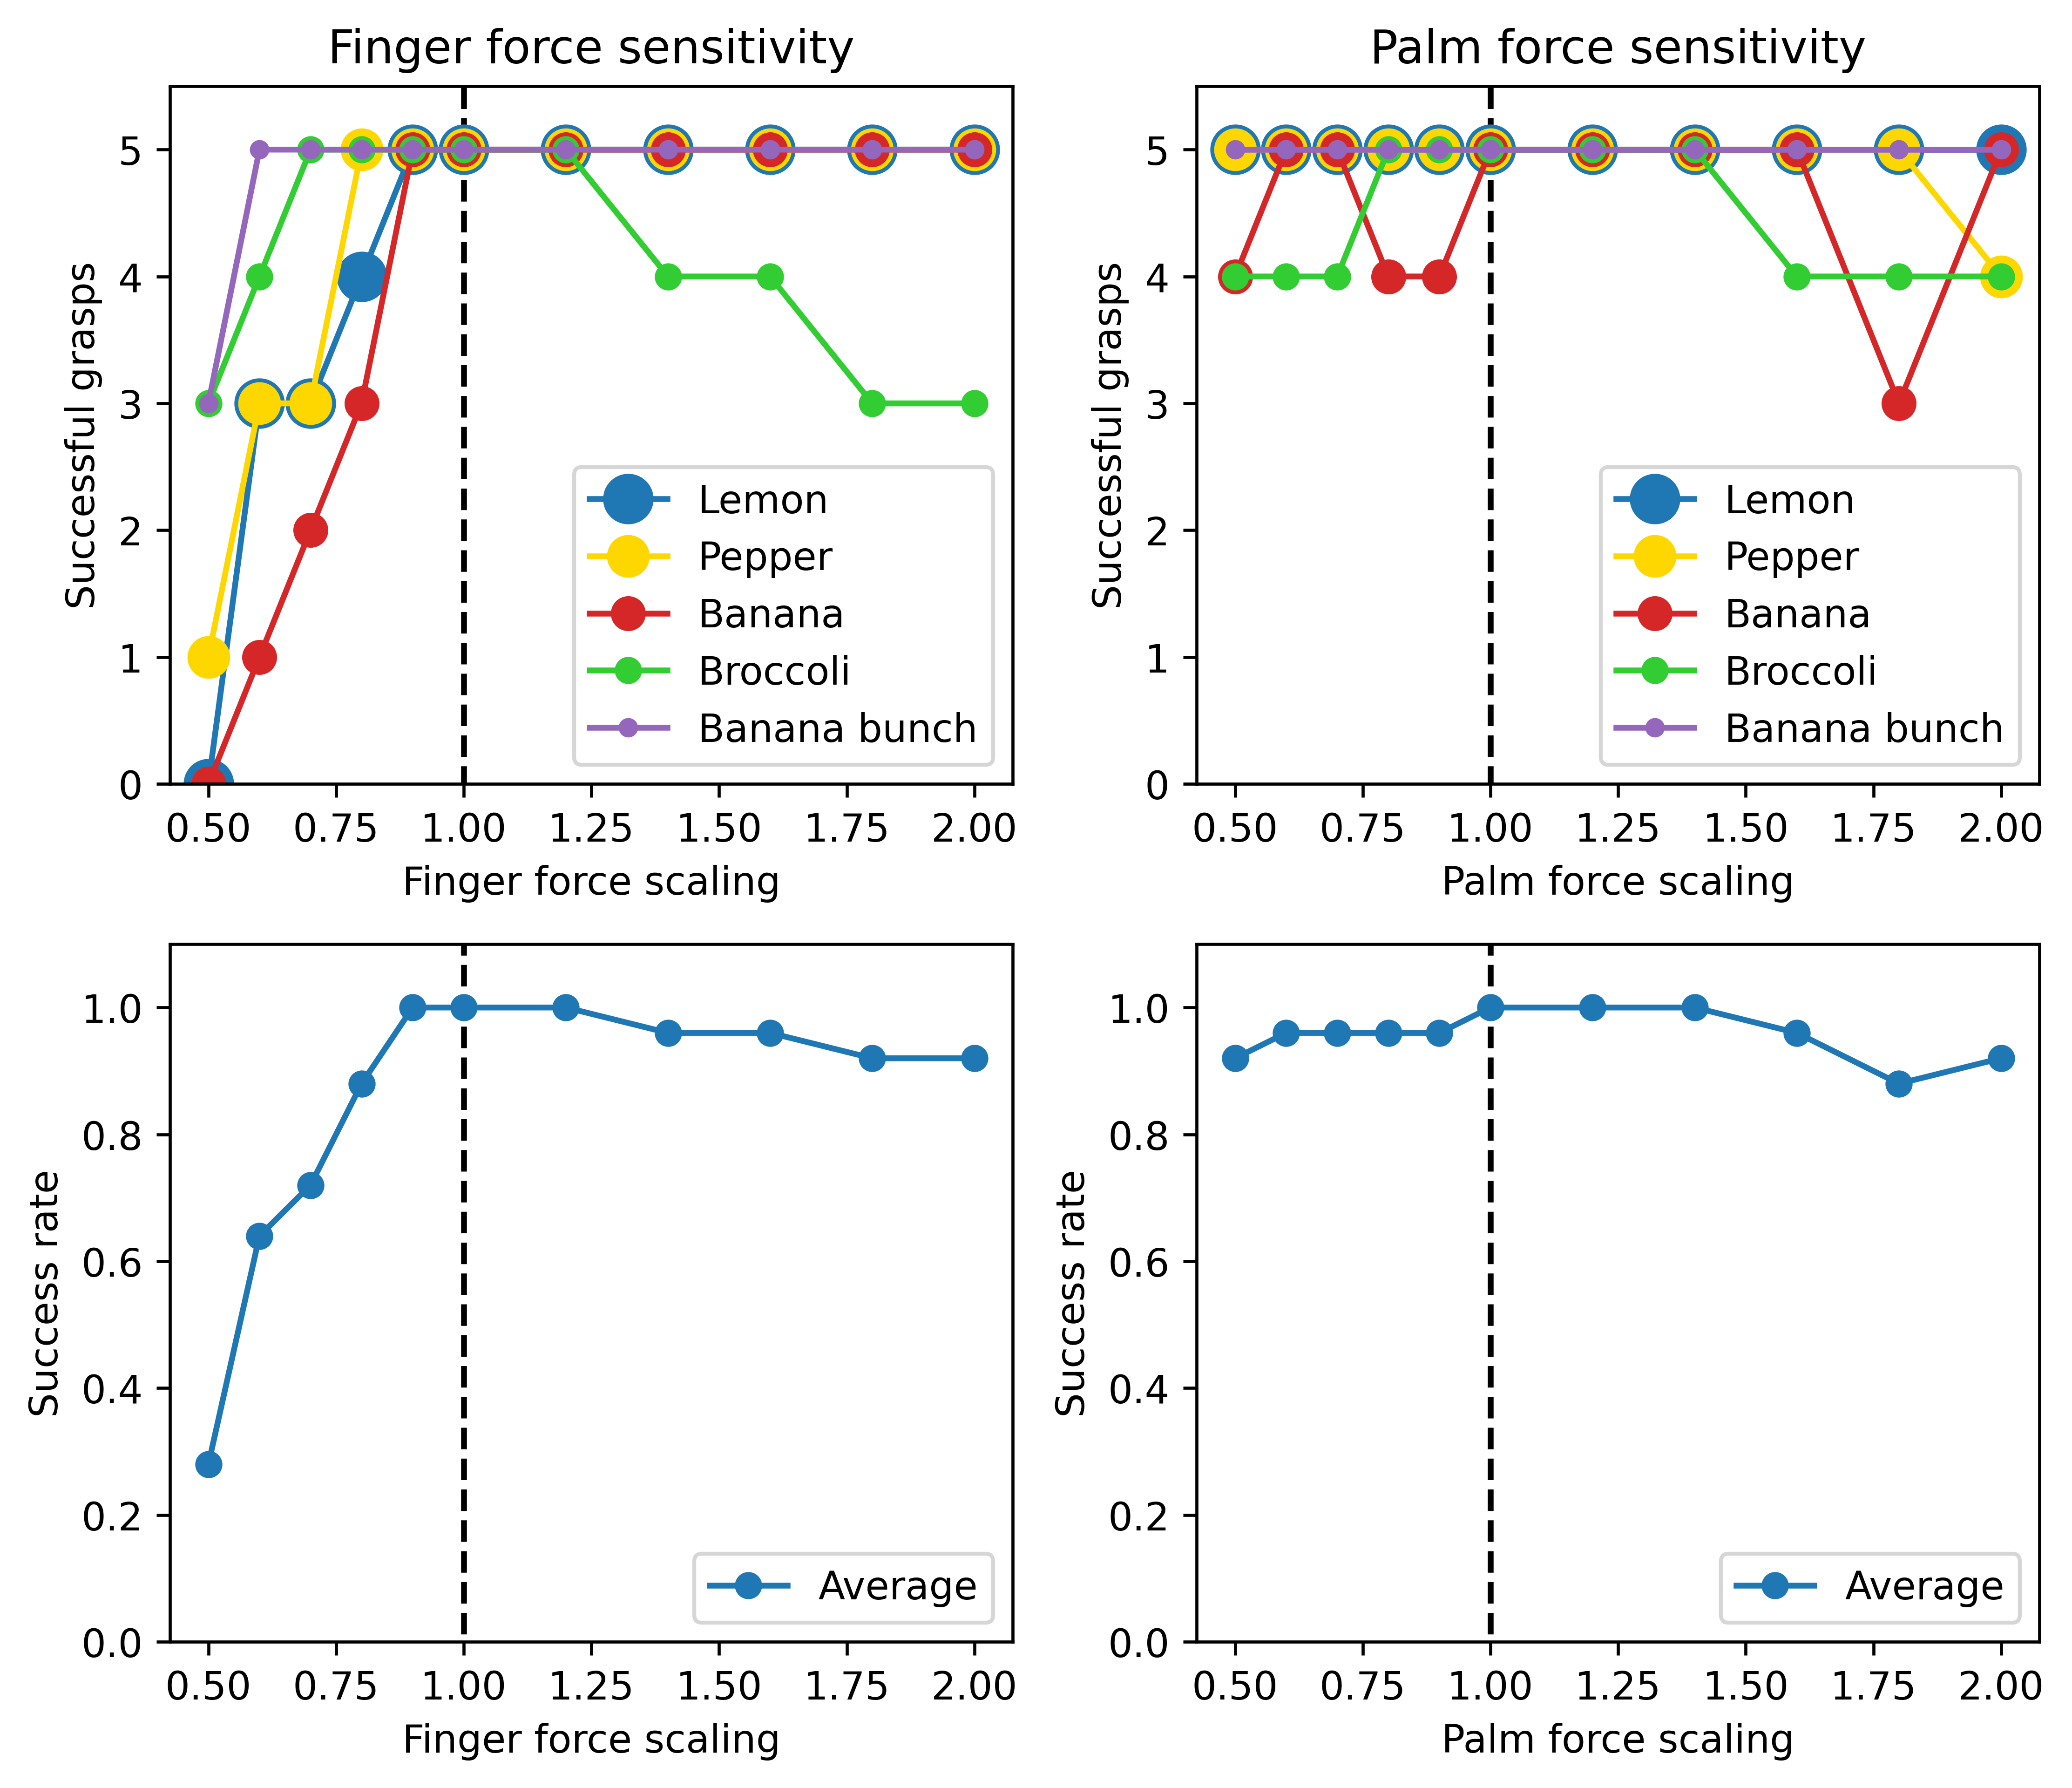

In [10]:
fig, axs = plt.subplots(2, 2)

axs[0][0].plot([1.0, 1.0], [-1, 10], "k--")
axs[0][1].plot([1.0, 1.0], [-1, 10], "k--")
axs[1][0].plot([1.0, 1.0], [-1, 10], "k--")
axs[1][1].plot([1.0, 1.0], [-1, 10], "k--")

colors = ['#00BFFF', '#DC143C', '#32CD32', '#FFD700', '#9932CC']
colors = ['#4682B4', '#B22222', '#228B22', '#B8860B', '#9400D3']

# matplotlib default colours
colors = ['#1f77b4', '#FFD700', '#d62728', '#32CD32', '#9467bd']

# colors = ['#00BFFF', '#DC143C', '#FFD700', '#32CD32', '#9932CC']

for i, name in enumerate(names[:-1]):
  axs[0][0].plot(finger_scaling_data["Position"], finger_scaling_data[name], marker="o", label=name, markersize=12-2*i, color=colors[i])
  axs[0][1].plot(palm_scaling_data["Position"], palm_scaling_data[name], marker="o", label=name, markersize=12-2*i, color=colors[i])
axs[1][0].plot(finger_scaling_data["Position"], finger_scaling_data["Average"] / (5), marker="o", label="Average")
axs[1][1].plot(palm_scaling_data["Position"], palm_scaling_data["Average"] / (5), marker="o", label="Average")

axs[0][0].set_ylim(0, 5.5)
axs[0][1].set_ylim(0, 5.5)
axs[1][0].set_ylim(0, 1.1)
axs[1][1].set_ylim(0, 1.1)

# axs[0][0].grid()
# axs[0][1].grid()
# axs[1][0].grid()
# axs[1][1].grid()

axs[0][0].set_ylabel("Successful grasps")
axs[0][1].set_ylabel("Successful grasps")
axs[1][0].set_ylabel("Success rate")
axs[1][1].set_ylabel("Success rate")

axs[0][0].set_xlabel("Finger force scaling")
axs[0][1].set_xlabel("Palm force scaling")
axs[1][0].set_xlabel("Finger force scaling")
axs[1][1].set_xlabel("Palm force scaling")

# axs[0][0].set_ylabel("Successful grasps")
# axs[1][0].set_ylabel("Successful grasps")
# axs[1][0].set_xlabel("Finger force scaling")
# axs[1][1].set_xlabel("Palm force scaling")

axs[0][0].set_title("Finger force sensitivity")
axs[0][1].set_title("Palm force sensitivity")

axs[0][0].legend(loc="lower right")
axs[0][1].legend(loc="lower right")
axs[1][0].legend(loc="lower right")
axs[1][1].legend(loc="lower right")

fig.set_size_inches(7.5, 6.5)
fig.tight_layout()

if True and overwrite: fig.savefig(save_path + "sensor_scaling.png")